# CMS classification with the CMScaller package

- [paper](https://www.nature.com/articles/s41598-017-16747-x)
- [github](https://github.com/peterawe/CMScaller)

>The CMScaller package provides Consensus Molecular Subtype (CMS) classification of colorectal cancer pre-clinical models [Guinney 2015; Eide 2017; Sveen 2017]. A small ensembl of functions for evaluating and visualizing results is also included. The core algorithm is Nearest Template Prediction (NTP) algorithm proposed by Yujin Hoshida [Hoshida 2010].

>Colorectal cancers (CRCs) can be divided into four gene expression-based biologically distinct consensus molecular subtypes (CMS). This classification provides a potential framework for stratified treatment, but to identify novel CMS-drug associations, translation of the subtypes to pre-clinical models is essential. The currently available classifier is dependent on gene expression signals from the immune and stromal compartments of tumors and fails to identify the poor-prognostic CMS4-mesenchymal group in immortalized cell lines, patient-derived organoids and xenografts. To address this, we present a novel CMS classifier based on a filtered set of cancer cell-intrinsic, subtype-enriched gene expression markers. This new classifier, referred to as CMScaller, recapitulated the subtypes in both in vitro and in vivo models (551 in total).
>
>Gene expression profiling shows promise to identify clinically important subtypes2,3,4,5,6, including a mesenchymal-like subgroup with high stromal infiltration, poor patient prognosis7 and poor response to standard treatments such as oxaliplatin8 and antibodies against EGFR3,5,9. Based on gene expression profiles from close to 4000 primary tumors, an expert consortium recently proposed a classification scheme reconciling this work and dividing CRCs into four biologically distinct subtypes10. In this consensus system:
>- CMS1-immune comprises most tumors with microsatellite instability (MSI) and is characterized by infiltration of activated immune cells. 
>CMS2-canonical and CMS3-metabolic both show epithelial characteristics, with oncogene amplification and high WNT and MYC signaling predominantly in CMS2 and metabolic reprogramming in CMS3. 
>CMS4 comprises the more mesenchymal-like cancers, with high stromal infiltration and poor patient prognosis10,11. 

Shall we use normalized data or not? Eric used "unnormalized gene expression counts" in his and Soulafa's paper. I will do both here to see whether differences arise.

In [93]:
if (!"CMScaller" %in% installed.packages()) {devtools::install_github('peterawe/CMScaller')}
library(CMScaller)

In [ ]:
input_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/adata_subset_stripped.h5ad"
output_csv = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/CMScaller_subset.csv"
clusters_file = "/data/cephfs-1/home/users/cemo10_c/work/scRNA/scRNA_preprocessing_pipeline/results/chosen_branch/clusters_scmiko_subset_chosen_res.csv"

In [95]:
suppressPackageStartupMessages({library(Seurat)})
srt = schard::h5ad2seurat(input_file)
srt[['RNA']]$data = as.matrix(schard::h5ad2Matrix(input_file, name = "/layers/log1p_norm_of_counts"))
stopifnot(!(all(srt[['RNA']]$data[1:50]%%1 == 0))) # check values (not integer)
names(srt@reductions) = c('diffmap', 'pca', 'tsne', 'umap')

# set colors for CMS types
cms_col = c('CMS1' = '#e69f00', 'CMS2' = '#0072b2', 'CMS3' = '#cc79a7', 'CMS4' = '#009e73', "NA" = 'lightgrey')

srt

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


An object of class Seurat 
11449 features across 22799 samples within 1 assay 
Active assay: RNA (11449 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: diffmap, pca, tsne, umap

## With normalized data

### Pseudo-bulk per cluster


In [96]:
clusters = read.csv(clusters_file) |> dplyr::rename(cluster = !!2) |> tibble::column_to_rownames("X")
stopifnot(all(rownames(srt@meta.data) == rownames(clusters))) # check if same cells
srt$clusters = clusters

90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

7 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   0    1    1    2    3 


3/7 samples set to NA



,prediction,d.CMS1,d.CMS2,d.CMS3,d.CMS4,p.value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g0,CMS2,0.7343069,0.6933453,0.7659583,0.7652912,0.01498501,0.03146853
g1,CMS4,0.6371562,0.6380322,0.6717290,0.5820601,0.01798202,0.03146853
g2,CMS4,0.6873285,0.7212273,0.7100565,0.6735170,0.00100000,0.00350000
g3,NA,0.6679170,0.7324366,0.6904481,0.7124488,1.00000000,1.00000000
g4,NA,0.7263644,0.6732972,0.7094187,0.6438408,0.66433566,0.93006993
g5,NA,0.7377200,0.7543160,0.7802921,0.7816309,0.99300699,1.00000000
g6,CMS3,0.7417707,0.7304338,0.6356914,0.7792252,0.00100000,0.00350000


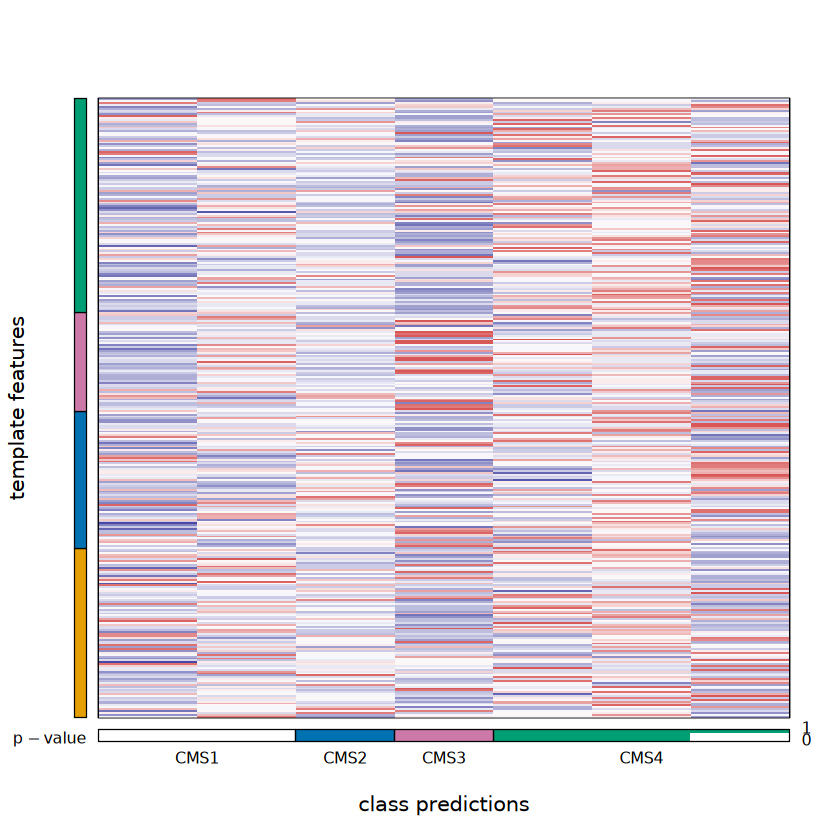

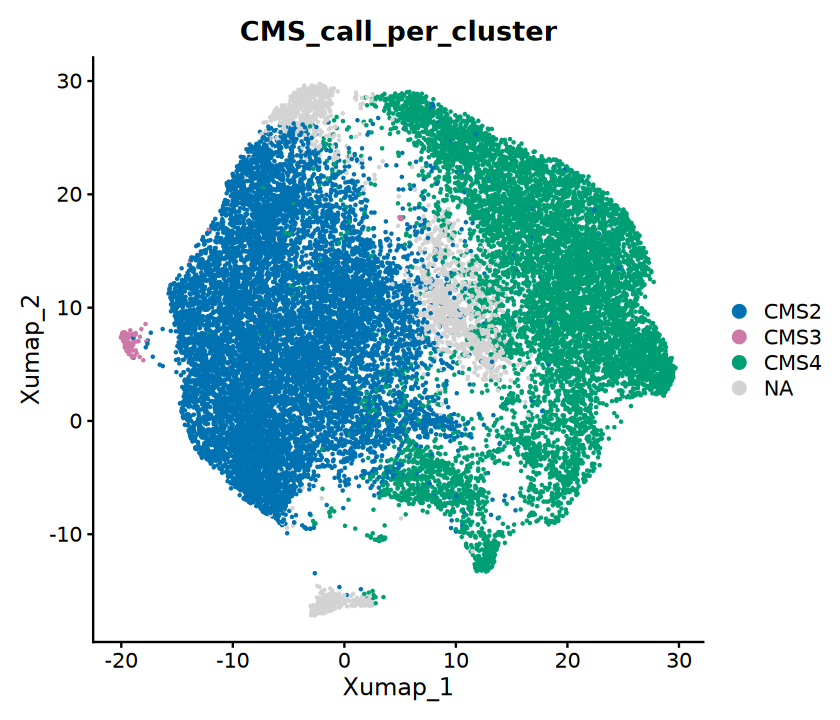

In [97]:
aex_per_cluster = AverageExpression(srt, layer = "data", assays = "RNA", return.seurat = F, group.by = "clusters")$RNA
options(repr.plot.width = 7, repr.plot.height = 7)
res = CMScaller(emat = as.matrix(aex_per_cluster), rowNames = "symbol", RNAseq=F, seed=1)

res
df = data.frame(cluster = gsub("g","",rownames(res)), CMS = res$prediction, stringsAsFactors = T)
srt$CMS_call_per_cluster = df$CMS[match(srt$clusters, df$cluster)]
options(repr.plot.width = 7, repr.plot.height = 6)
DimPlot(srt, group.by = "CMS_call_per_cluster", cols = cms_col, na.value="lightgrey")

### Pseudo-bulk per sample and cluster


90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

96 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   9    4   11    7   65 


65/96 samples set to NA



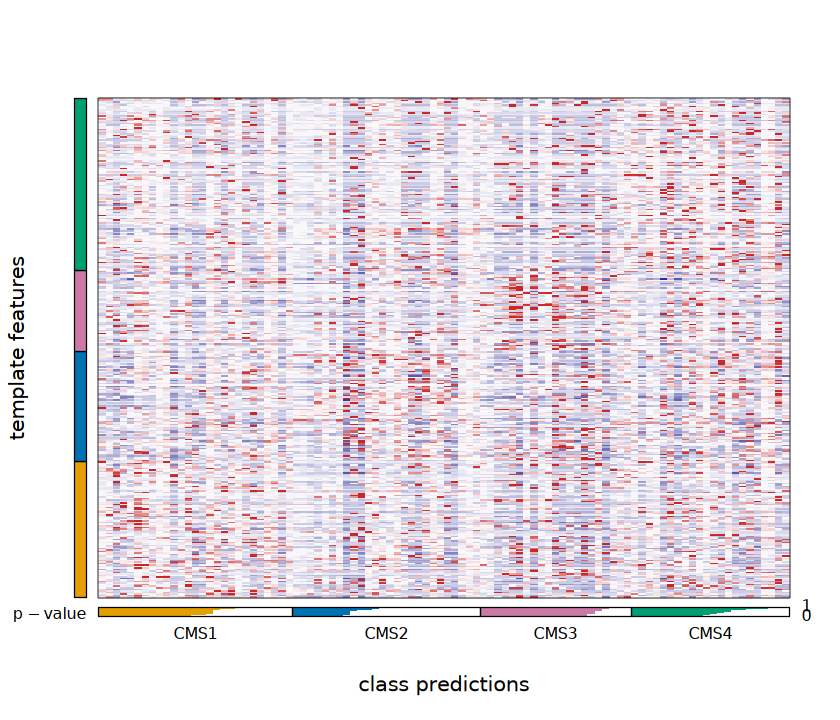

In [98]:
aex_per_sample_and_cluster = AverageExpression(srt, layer = "data", assays = "RNA", return.seurat = F, group.by = c("sample", "clusters"))$RNA
res = CMScaller(emat = as.matrix(aex_per_sample_and_cluster), rowNames = "symbol", RNAseq=F, seed=1)

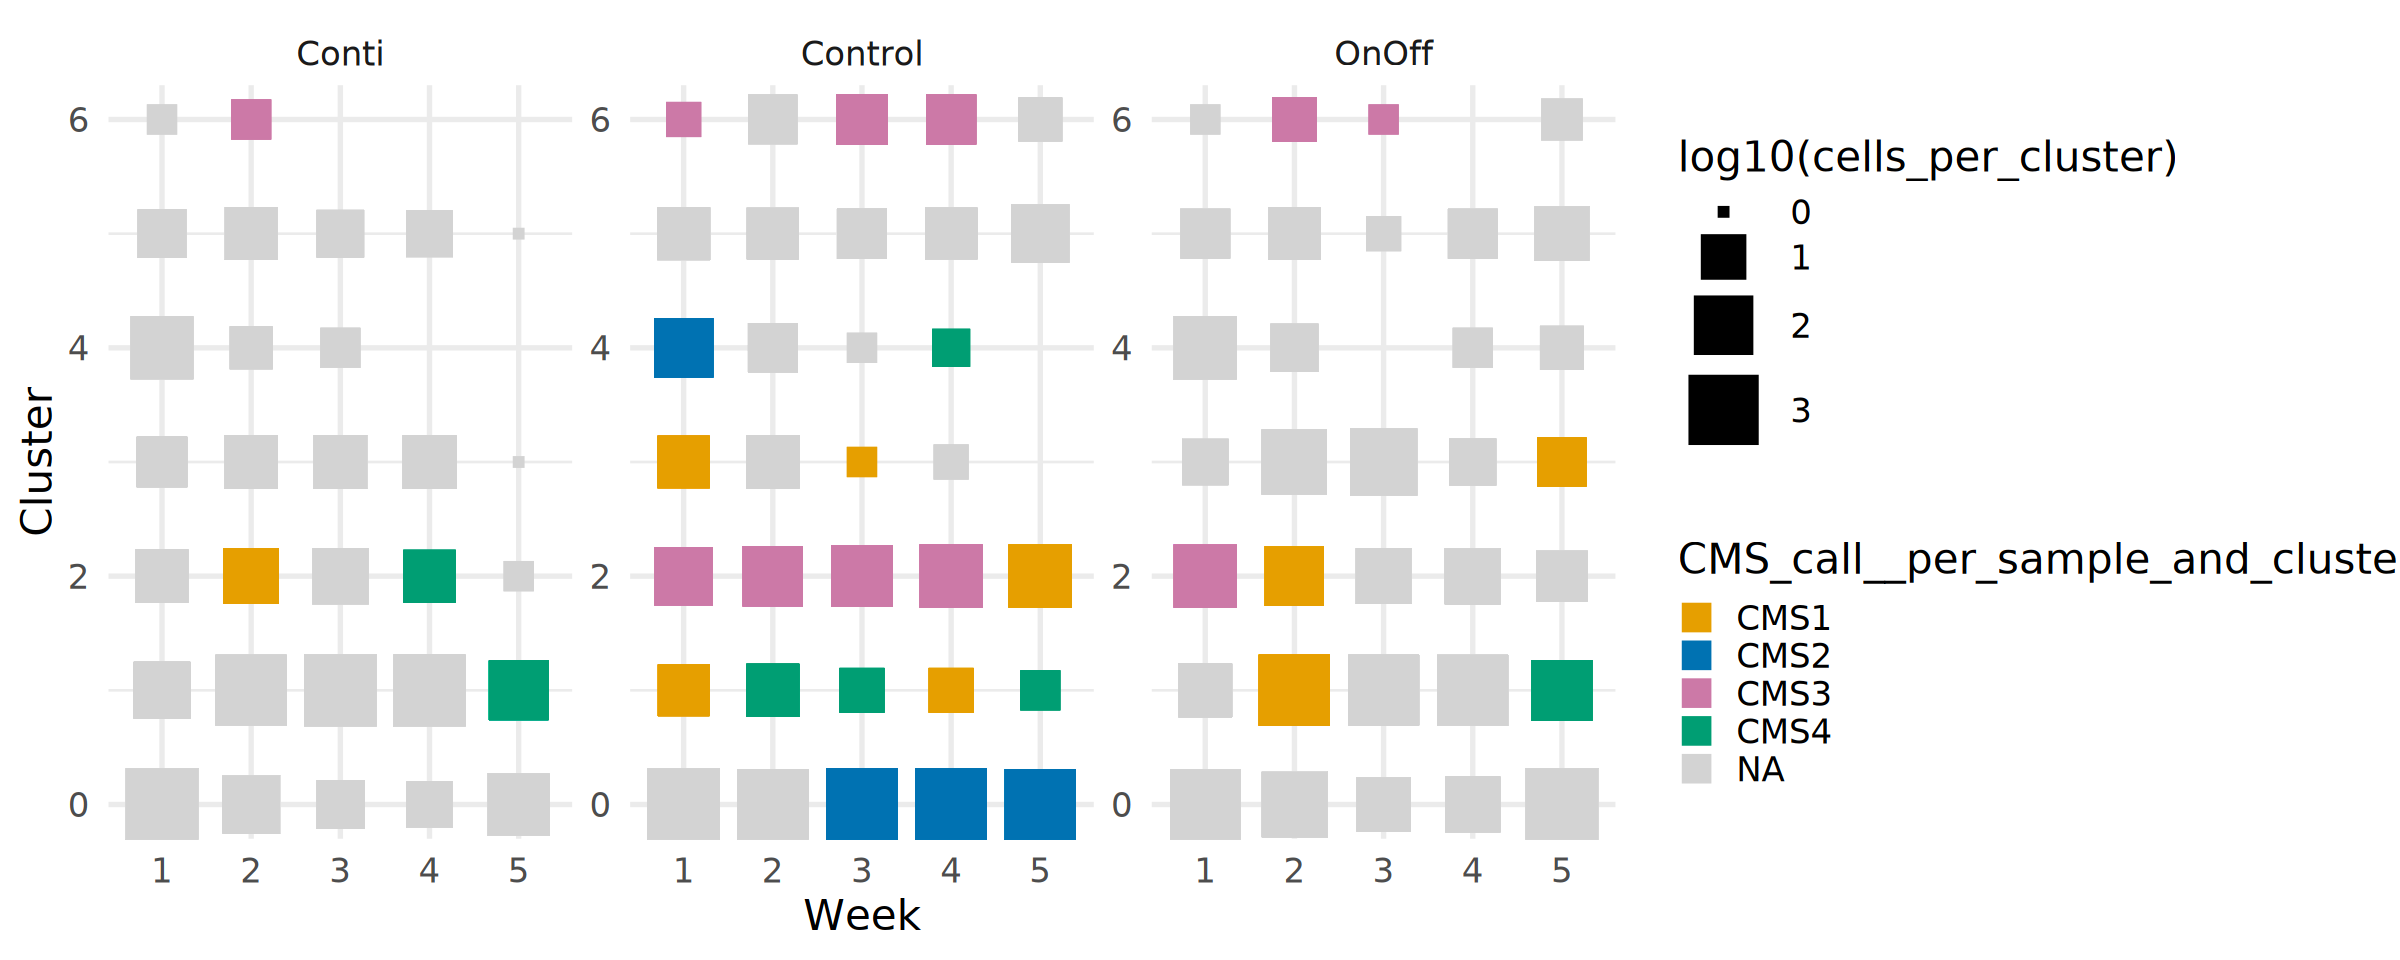

In [99]:
df = data.frame(sample_cluster = rownames(res),
                CMS = res$prediction, stringsAsFactors = T)

srt$CMS_call__per_sample_and_cluster = df$CMS[
    match(paste0(gsub("_", "-", srt$sample), '_', srt$clusters), df$sample_cluster)
    ]
    
srt$cells_per_cluster = as.numeric(table(paste0(srt$sample, '_', srt$clusters))[
    match(paste0(srt$sample, '_', srt$clusters), 
    names(table(paste0(srt$sample, '_', srt$clusters))))
    ])

# plot with CMS type per cluster and sample and the size of rectangles proportional to the number of cells in the cluster
library(tidyverse)
options(repr.plot.width = 20, repr.plot.height = 8)
srt@meta.data %>%
    ggplot(aes(x = week, y = clusters, color = CMS_call__per_sample_and_cluster, size = log10(cells_per_cluster))) +
    geom_point(shape = 15) +
    scale_size_continuous(range = c(3, 20)) +
    scale_color_manual(values = cms_col, na.value="lightgrey", guide = guide_legend(override.aes = list(size = 8))) +
    theme_minimal(base_size = 25) +
    labs(x = "Week", y = "Cluster", fill = "PDS type") +
    facet_wrap(~treatment, scales = "free_y")

### Pseudobulk per sample


90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

15 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   1    1    3    2    8 


8/15 samples set to NA



,prediction,d.CMS1,d.CMS2,d.CMS3,d.CMS4,p.value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C-1,NA,0.7650159,0.7737966,0.7614328,0.8217706,0.811188811,1.000000000
C-2,CMS2,0.7533264,0.7020614,0.7330279,0.7641660,0.022977023,0.049236478
C-3,CMS3,0.8207148,0.8025298,0.7897434,0.8470509,0.001000000,0.005000000
C-4,CMS3,0.8041994,0.7858843,0.7763431,0.8391753,0.001000000,0.005000000
C-5,CMS1,0.8077043,0.8203886,0.8144910,0.8603778,0.001998002,0.005994006
Conti-1,NA,0.6142900,0.6088166,0.6534670,0.6381375,1.000000000,1.000000000
Conti-2,NA,0.5878101,0.6377628,0.6316850,0.5656421,0.996003996,1.000000000
Conti-3,NA,0.7065164,0.7141035,0.7101869,0.6727066,0.373626374,0.622710623
Conti-4,NA,0.6685437,0.6569373,0.6641908,0.6130329,0.996003996,1.000000000


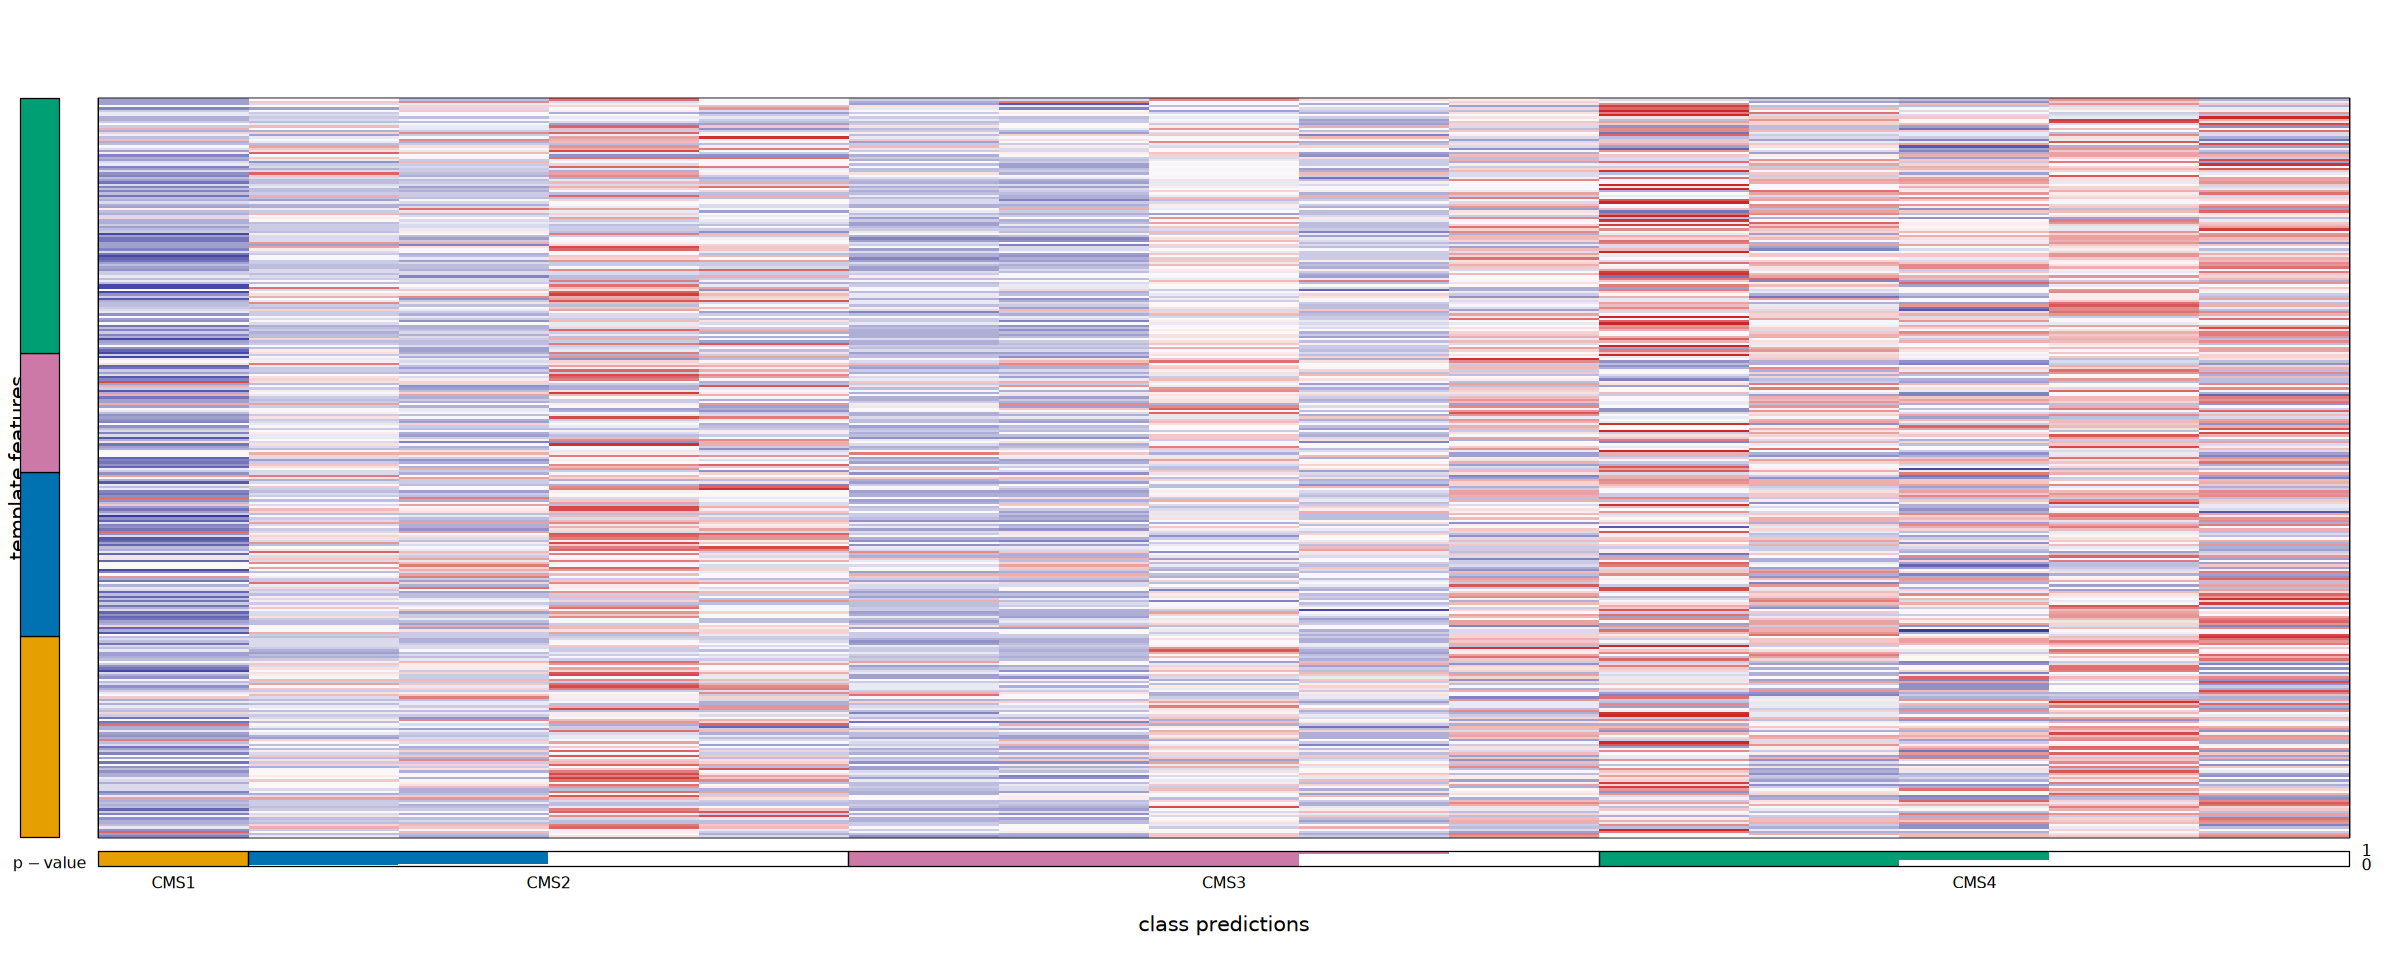

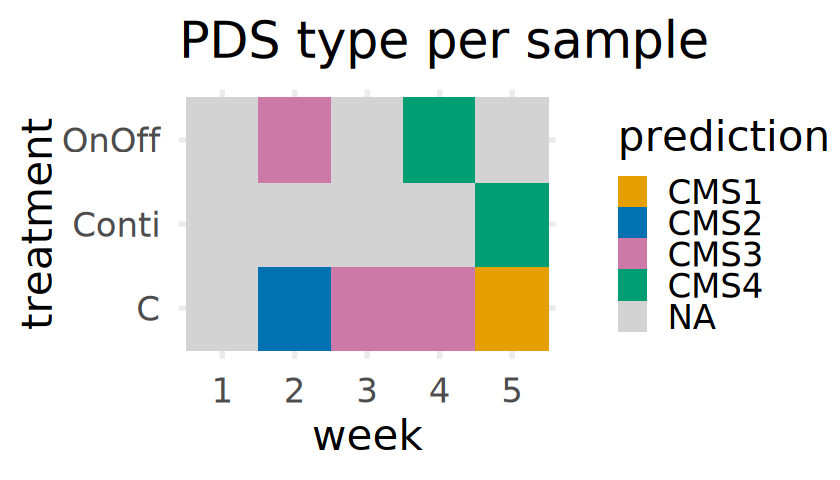

In [100]:
aex_per_sample = AverageExpression(srt, layer = "data", assays = "RNA", return.seurat = F, group.by = c("sample"))$RNA
res = CMScaller(emat = as.matrix(aex_per_sample), rowNames = "symbol", RNAseq=F, seed=1)

res

options(repr.plot.width = 7, repr.plot.height = 4)
res %>%
    rownames_to_column("Sample_ID") %>%
    mutate(week = str_remove(Sample_ID, ".*-"),
           treatment = str_remove(Sample_ID, "-.*")) %>%
    ggplot(aes(x = week, y = treatment, fill = prediction)) +
        geom_tile() +
        scale_fill_manual(values = cms_col, na.value="lightgrey") +
        labs(title = "PDS type per sample", x = "week", y = "treatment") +
        theme_minimal(base_size = 25)

## With raw counts (no normalization)

### Pseudo-bulk per cluster


In [101]:
clusters = read.csv(clusters_file) |> dplyr::rename(cluster = !!2) |> tibble::column_to_rownames("X")
stopifnot(all(rownames(srt@meta.data) == rownames(clusters))) # check if same cells
srt$clusters = clusters

90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

7 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

Warning message in xr - xl:
“longer object length is not a multiple of shorter object length”
predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   0    0    3    0    4 


4/7 samples set to NA



,prediction,d.CMS1,d.CMS2,d.CMS3,d.CMS4,p.value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g0,NA,0.5277671,0.5199432,0.5515219,0.5019984,1.000000000,1.00000000
g1,NA,0.5361352,0.5725371,0.5594165,0.4549939,0.045954046,0.06713287
g2,CMS3,0.8472098,0.8472643,0.8209848,0.8827404,0.001000000,0.00350000
g3,CMS3,0.8457851,0.8520202,0.8281744,0.8890313,0.001000000,0.00350000
g4,NA,0.8614707,0.8411686,0.8498191,0.8775788,0.047952048,0.06713287
g5,NA,0.8607914,0.8465410,0.8513636,0.8947721,0.218781219,0.25524476
g6,CMS3,0.8616580,0.8482637,0.8425982,0.8966660,0.005994006,0.01398601


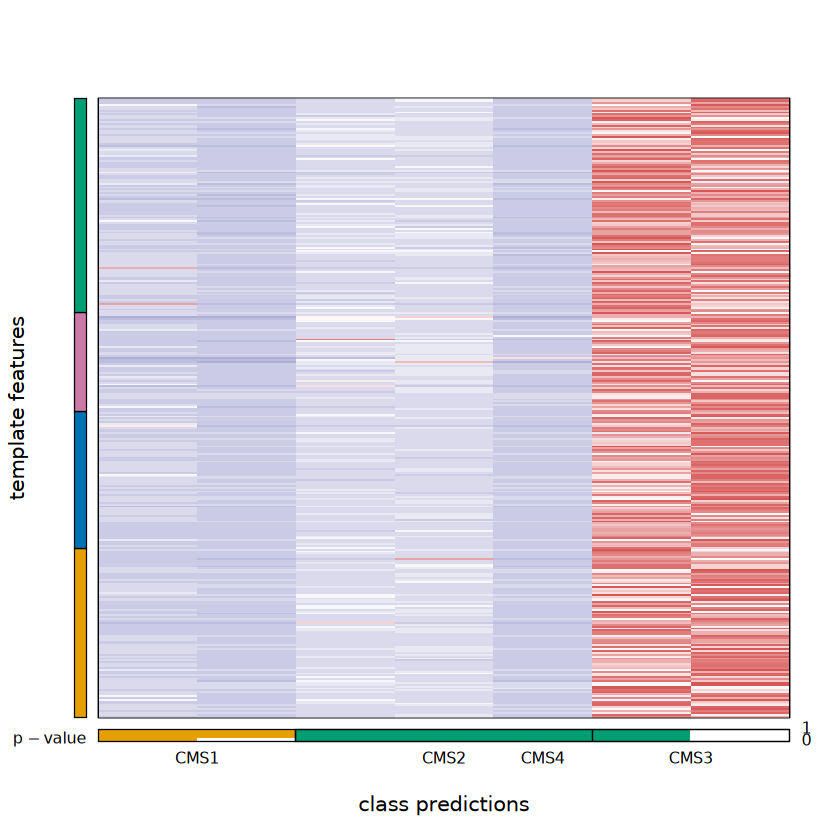

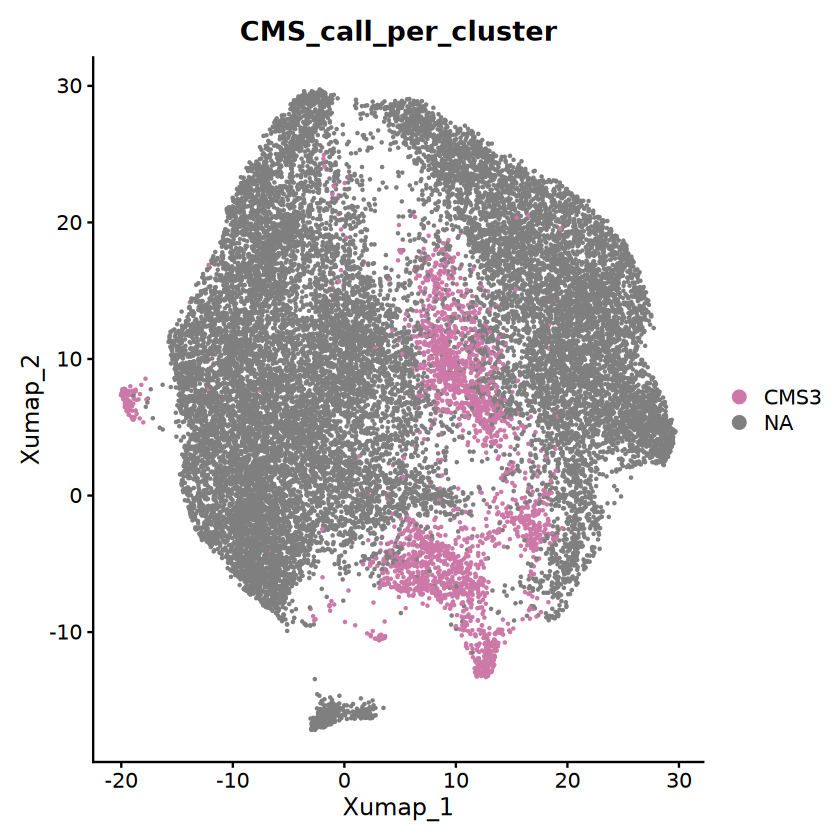

In [102]:
aex_per_cluster = AggregateExpression(srt, assays = "RNA", return.seurat = F, group.by = "clusters")$RNA
options(repr.plot.width = 7, repr.plot.height = 7)
res = CMScaller(emat = as.matrix(aex_per_cluster), rowNames = "symbol", RNAseq=F, seed=1)

res
df = data.frame(cluster = gsub("g","",rownames(res)), CMS = res$prediction, stringsAsFactors = T)
srt$CMS_call_per_cluster = df$CMS[match(srt$clusters, df$cluster)]
DimPlot(srt, group.by = "CMS_call_per_cluster", cols = cms_col)

### Pseudo-bulk per sample and cluster


90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

96 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   1    0   12    3   80 


80/96 samples set to NA



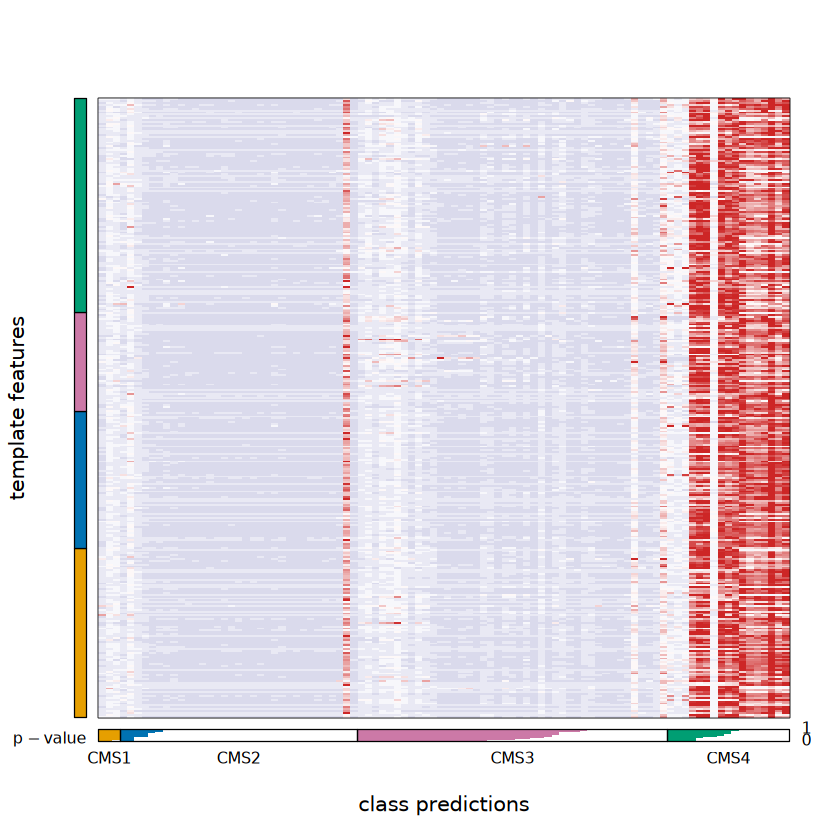

In [103]:
aex_per_sample_and_cluster = AggregateExpression(srt, assays = "RNA", return.seurat = F, group.by = c("sample", "clusters"))$RNA
res = CMScaller(emat = as.matrix(aex_per_sample_and_cluster), rowNames = "symbol", RNAseq=F, seed=1)

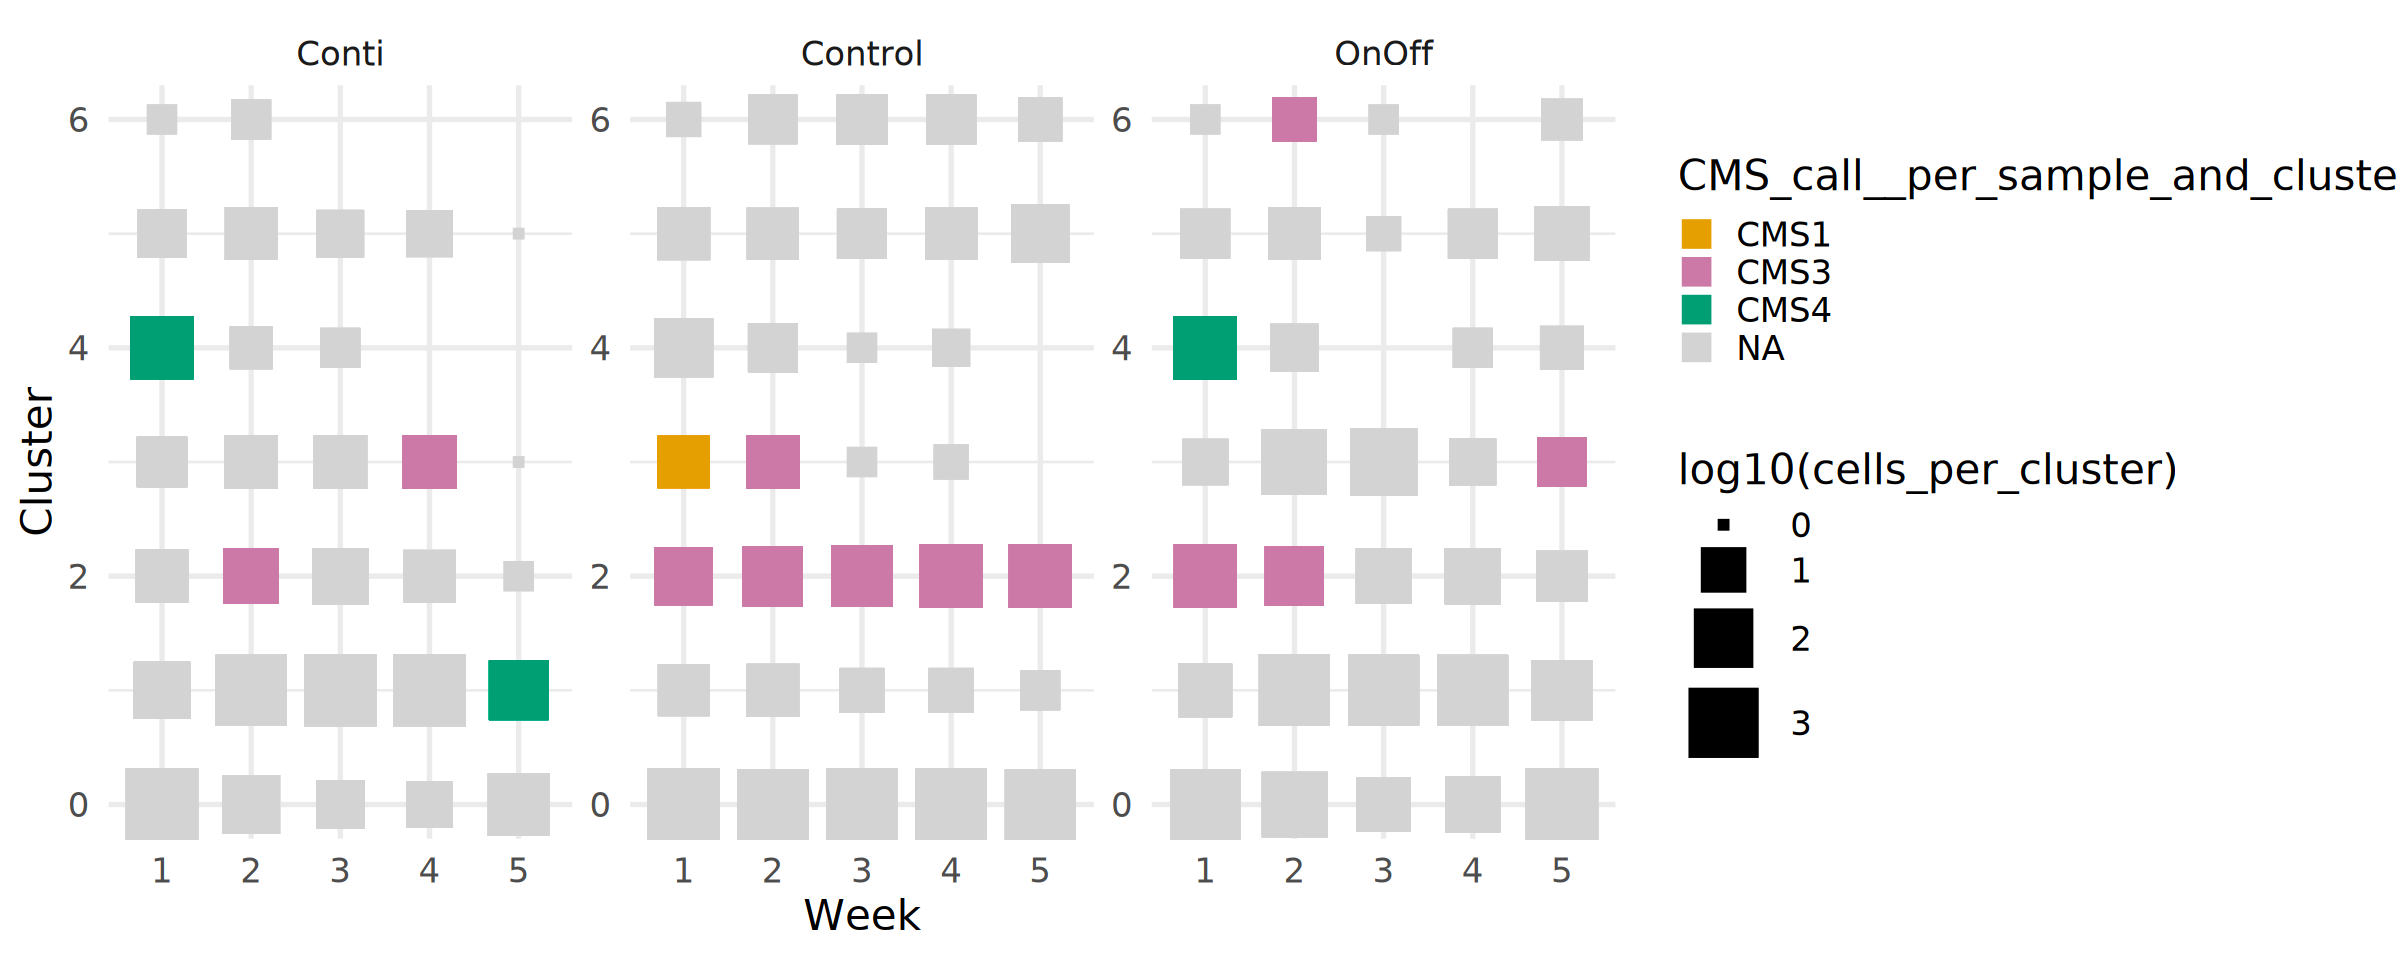

In [104]:
df = data.frame(sample_cluster = rownames(res),
                CMS = res$prediction, stringsAsFactors = T)

srt$CMS_call__per_sample_and_cluster = df$CMS[
    match(paste0(gsub("_", "-", srt$sample), '_', srt$clusters), df$sample_cluster)
    ]
    
srt$cells_per_cluster = as.numeric(table(paste0(srt$sample, '_', srt$clusters))[
    match(paste0(srt$sample, '_', srt$clusters), 
    names(table(paste0(srt$sample, '_', srt$clusters))))
    ])

# plot with CMS type per cluster and sample and the size of rectangles proportional to the number of cells in the cluster
library(tidyverse)
options(repr.plot.width = 20, repr.plot.height = 8)
srt@meta.data %>%
    ggplot(aes(x = week, y = clusters, color = CMS_call__per_sample_and_cluster, size = log10(cells_per_cluster))) +
    geom_point(shape = 15) +
    scale_size_continuous(range = c(3, 20)) +
    scale_color_manual(values = cms_col, na.value="lightgrey", guide = guide_legend(override.aes = list(size = 8))) +
    theme_minimal(base_size = 25) +
    labs(x = "Week", y = "Cluster", fill = "PDS type") +
    facet_wrap(~treatment, scales = "free_y")

### Pseudobulk per sample


90/11449 rownames [NA.number] (no valid translation)

0/11449 rownames [id.number] (translation gives duplicates)

cosine correlation distance

164/529 templates features not in emat, discarded

15 samples; 4 classes; 70-132 features/class

serial processing; 1000 permutation(s)...

predicted samples/class (FDR<0.05)




CMS1 CMS2 CMS3 CMS4 <NA> 
   0    3    1    1   10 


10/15 samples set to NA



,prediction,d.CMS1,d.CMS2,d.CMS3,d.CMS4,p.value,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C-1,NA,0.6596356,0.6393863,0.6554786,0.7042551,1.00000000,1.0000000
C-2,CMS2,0.7916549,0.7482957,0.7644047,0.8131416,0.00100000,0.0030000
C-3,CMS2,0.8152529,0.7847133,0.7944829,0.8499500,0.00100000,0.0030000
C-4,CMS2,0.7701717,0.7299226,0.7329994,0.7957835,0.00100000,0.0030000
C-5,CMS3,0.8158830,0.8153411,0.8117871,0.8701594,0.00100000,0.0030000
Conti-1,NA,0.5514704,0.5577364,0.5989798,0.5545993,1.00000000,1.0000000
Conti-2,NA,0.6326561,0.7065170,0.6943185,0.6159134,0.04695305,0.1173826
Conti-3,NA,0.6750135,0.6933102,0.6947137,0.6244649,0.13886114,0.2975596
Conti-4,NA,0.6832210,0.6838711,0.6792446,0.6164347,0.18081918,0.3390360


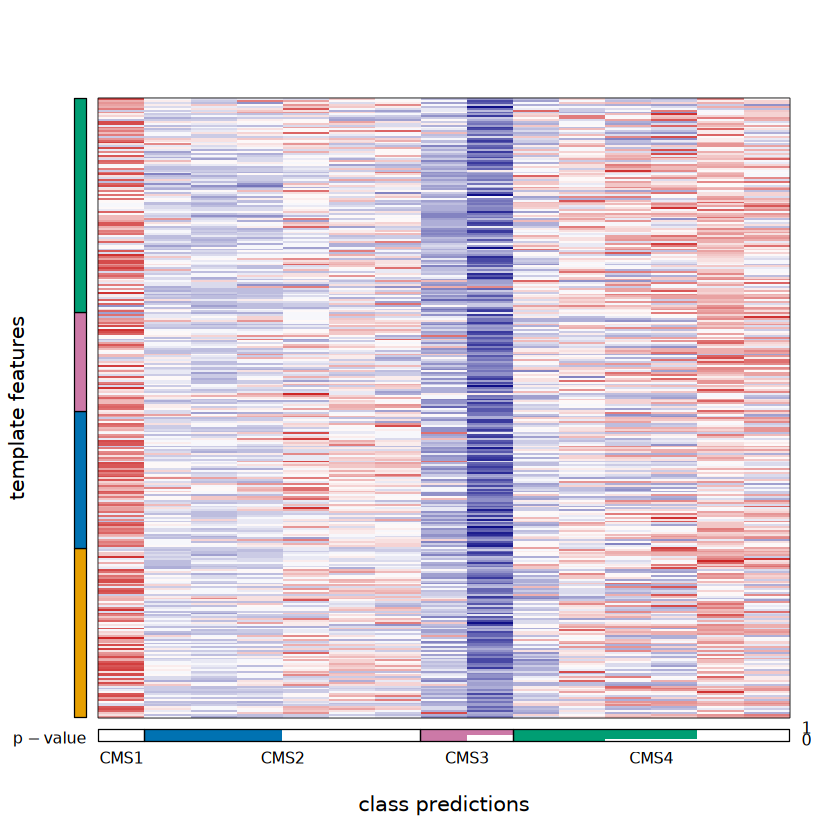

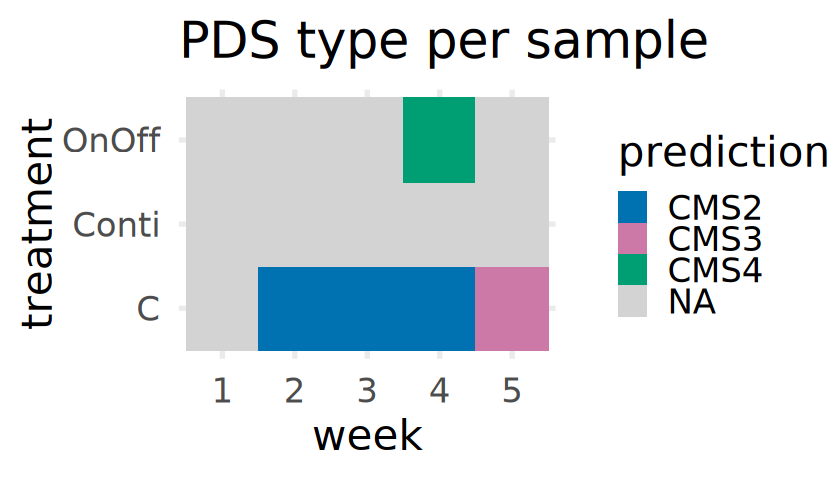

In [105]:
aex_per_sample = AggregateExpression(srt, assays = "RNA", return.seurat = F, group.by = c("sample"))$RNA
options(repr.plot.width = 7, repr.plot.height = 7)
res = CMScaller(emat = as.matrix(aex_per_sample), rowNames = "symbol", RNAseq=F, seed=1)

res
library(tidyverse)
options(repr.plot.width = 7, repr.plot.height = 4)
res %>%
    rownames_to_column("Sample_ID") %>%
    mutate(week = str_remove(Sample_ID, ".*-"),
           treatment = str_remove(Sample_ID, "-.*")) %>%
    ggplot(aes(x = week, y = treatment, fill = prediction)) +
        geom_tile() +
        scale_fill_manual(values = cms_col, na.value="lightgrey") +
        labs(title = "PDS type per sample", x = "week", y = "treatment") +
        theme_minimal(base_size = 25)